Environment and packages: 
- Julia 1.9.3
- Yao v0.7.4
- YaoPlots v0.7.3
- YaoExtensions v0.2.5
- StatsBase v0.33.21
- MAT v0.10.6
- Optimisers v0.3.1
- Plots v1.39.0
- PyPlot v2.11.2
- NumPyArrays v0.1.1
- NPZ v0.4.3
- PyCall v1.96.1
- KrylovKit v0.6.0
- JSON v0.21.4

In [1]:
using Yao, YaoPlots, YaoExtensions
using LinearAlgebra, Statistics, Random, StatsBase, MAT, Printf
using Optimisers
using Plots, PyPlot
using NumPyArrays
using NPZ
using PyCall
using KrylovKit: eigsolve
using Base
using JSON

py"""
import os
import sys

sys.path.insert(0, os.getcwd())

from dmd_sw import sliding_window_dmd_nonsq
"""

"""
Run Dynamic Mode Decomposition (with the sliding-window extension) with Julia Yao circuits

### Input

- `params` -- parameters to be fed into the computation of DMD
    shape: (`num_iters_sim`, `num_params`)
- `circuit` -- Julia Yao quantum circuit
- `hamiltonian` -- Hamiltonian in VQE
- `num_iters_sim` -- number of iterations for VQE simulation
- `num_iters_dmd` -- number of iterations for DMD prediction
- `window_size` -- size of the sliding window (`window_size=1` reduces the sliding-window DMD to standard DMD)
- `print_every` -- print every how many iterations

### Output

-- array of DMD-predicted energies
    length: `num_iters_dmd`
-- DMD-predicted parameters
    shape: (`num_params`, `num_iters_dmd`)
-- Starting index from the optimal point from the control scheme (Int)
"""
function dmd_run(
    ;params,
    circuit,
    hamiltonian,
    num_iters_sim, num_iters_dmd, window_size,
    print_every=1,
)
    n = hamiltonian.n
    num_params = nparameters(circuit)

    dmd_params_pred = zeros(num_params, num_iters_dmd)

    @time begin

        flush(stdout)
        
        dmd_params_pred[:, :] = py"sliding_window_dmd_nonsq"(
            params=NumPyArray(params)[:, :],
            window_size=window_size,
            start_time=0,
            end_time=num_iters_sim - window_size,
            pred_time_len=num_iters_dmd,
        )
        t2 = time()
    end

    energy_history_dmd = Float64[]
    
    for i in 1:num_iters_dmd
    
        theta = dmd_params_pred[:, i]

        dispatch!(circuit, theta)

        energy = real(expect(hamiltonian, zero_state(n)=>circuit))
        if i % print_every == 0
            @printf("\nStep = %d, energy = %.3f\n", i, energy)
            flush(stdout)
        end

        push!(energy_history_dmd, energy)
    end
    
    opt_start = argmin(energy_history_dmd)
    
    energy_history_dmd, transpose(dmd_params_pred), opt_start

end

"""
The Hamiltonian of the quantum transverse-field Ising model
    `H = -sum_i Z_i Z_{i+1} - h sum_i X_i`

### Input

- `nbit` -- the number of qubits (Int)
- `h` -- the strength of the transverse field
- `periodic` -- is the periodic boundary condition applied?
    (Int. 0: open boundary condition; 1: periodic boundary condition)

### Output

-- The Hamiltonian of the quantum transverse-field Ising model
"""
function transverse_ising_(nbit::Int, h::Number; periodic::Int=1)
    ising_term = map(1:(periodic==1 ? nbit : nbit-1)) do i
        repeat(nbit,Z,(i,i%nbit+1))
    end |> sum
    -ising_term - h*sum(map(i->put(nbit,i=>X), 1:nbit))
end

"""Entangled layer of the Controlled-X gates"""
ent_cx(nbit::Int64) = (nbit%2 == 0) ? 
    chain(chain(nbit,control(i,i+1=>X) for i in 1:2:nbit-1),
          chain(nbit,control(i,i+1=>X) for i in 2:2:nbit-2)) : 
    chain(chain(nbit,control(i,i+1=>X) for i in 1:2:nbit-2),
          chain(nbit,control(i,i+1=>X) for i in 2:2:nbit-1))

"""Entangled layer of the Controlled-Z gates"""
ent_cz(nbit::Int64) = (nbit%2 == 0) ? 
    chain(chain(nbit,control(i,i+1=>Z) for i in 1:2:nbit-1),
          chain(nbit,control(i,i+1=>Z) for i in 2:2:nbit-2)) : 
    chain(chain(nbit,control(i,i+1=>Z) for i in 1:2:nbit-2),
          chain(nbit,control(i,i+1=>Z) for i in 2:2:nbit-1))

"""Circularly entangled layer of the Controlled-X gates"""
ent_circular_cx(nbit::Int64) = chain(
    chain(nbit, control(nbit, 1 => X)),
    chain(nbit, control(i, i+1 => X) for i in 1:nbit-1),
)

"""RX layer"""
rx_layer(nbit::Int64) = chain(put(nbit, i => Rx(0)) for i in 1:nbit)
"""RY layer"""
ry_layer(nbit::Int64) = chain(put(nbit, i => Ry(0)) for i in 1:nbit)
"""RZ layer"""
rz_layer(nbit::Int64) = chain(put(nbit, i => Rz(0)) for i in 1:nbit)
"""Parameters layer used in Hardware-Efficient Ansatz"""
params_layer(nbit::Int64) = chain(rx_layer(nbit), ry_layer(nbit))

"""
Run Variational Quantum Eigensolver (VQE)

### Input

- `ini_params` -- initial parameters
    shape: (`num_params`)
- `circuit` -- Julia Yao quantum circuit
- `hamiltonian` -- Hamiltonian in VQE
- `niters` -- number of iterations for VQE
- `lr` -- learning rate
- `optimizer_type` -- the type of optimizers
    ("adam": Adam; "gd": Gradient-Descent)
- `print_every` -- print every how many iterations

### Output
-- history of energies
    shape: (`niters`)
-- history of VQE parameters
    shape: (`niters`, `num_params`)
"""
function vqe_run(;ini_params, circuit, hamiltonian, niters, lr, optimizer_type="adam", print_every=1)
    
    seed = 42
    Random.seed!(seed)
    
    params = copy(ini_params)
    
    if optimizer_type == "adam"
        optimizer = Optimisers.setup(Optimisers.ADAM(lr), params)
    elseif optimizer_type == "gd"
        optimizer = Optimisers.setup(Optimisers.Descent(lr), params)
    end

    n = hamiltonian.n
    
    params_history = zeros(Float64, niters, size(ini_params, 1))
    energy_history = Float64[]

    for k in 1:niters
        
        grad_input, grad_params = expect'(hamiltonian, zero_state(n)=>circuit)
        Optimisers.update!(optimizer, params, grad_params)
        dispatch!(circuit, params)
        
        energy = real(expect(hamiltonian, zero_state(n)=>circuit))
        params_history[k, :] = copy(parameters(circuit))
        
        push!(energy_history, energy)
        if k % print_every == 0
            println("Step $k, energy = $energy")
        end
    end
    
    energy_history, params_history
end

"""
Run QuACK algorithm with VQE of quantum Ising model

### Input

- `n_qubits` -- number of qubits
- `t_field` -- the strength of the transverse field
- `pbc` -- is the periodic boundary condition (PBC) used?
    (Int. 0: open boundary condition; 1: periodic boundary condition)
- `n_tot` -- total number of iterations for VQE (as the benchmarking method)
- `n_sim` -- number of iterations for VQE simulation
- `n_dmd` -- number of iterations for DMD prediction
- `window_size` -- size of the sliding window (`window_size=1` reduces the sliding-window DMD to standard DMD)
- `n_pieces` -- number of VQE+DMD pieces in the alternating scheme
- `ansatz_type` -- the type of quantum ansatz
    ("RealAmplitudes": RealAmplitudes ansatz; "HEA": Hardware-Efficient Ansatz)
- `depth` -- circuit depth of quantum ansatz
- `lr` -- learning rate
- `optimizer_type` -- the type of optimizers
    ("adam": Adam; "gd": Gradient-Descent)
- `print_every` -- print every how many iterations
- `plot_prediction` -- plot DMD prediction or not
    (0: not; 1: plot the prediction)
- `seed` -- seed of the random number generator
- `rng_type` -- type of the random number generator
    ("Julia": Random of Julia; "Numpy": random of numpy)
- `save_params` -- save the parameters' history to files or not
- `use_early_termination` -- use the early termination or not
- `method_label` -- label of the method
"""
function quack_ising(
    ;n_qubits,
    t_field,
    pbc=1,
    n_tot=nothing,
    n_sim=nothing, n_dmd=nothing, window_size=1,
    n_pieces=10,
    ansatz_type="RealAmplitudes",
    depth=1,
    optimizer_type="gd",
    lr=0.01,
    print_every=10,
    plot_prediction=0,
    seed=0,
    rng_type="Julia",
    save_params=false,
    use_early_termination=false,
    method_label=nothing,
)
    
    early_termination = false

    if ansatz_type == "RealAmplitudes"
        reps = depth - 1
        circuit = chain(ry_layer(n_qubits), chain(chain(n_qubits, ent_circular_cx(n_qubits), ry_layer(n_qubits)) for _ in 1:reps))
    elseif ansatz_type == "HEA"
        circuit = chain(chain(n, params_layer(n_qubits), ent_cx(n_qubits)) for _ in 1:depth)
    end

    @show gatecount(circuit)
    @show num_params = nparameters(circuit)

    hamiltonian = transverse_ising_(n_qubits, t_field, periodic=pbc)

    w, v = eigsolve(mat(hamiltonian), 1, :SR, ishermitian=true)
    println("Ground state energy: $(w[1])")

    if rng_type == "Julia"
        Random.seed!(seed)
        @show ini_params = Random.rand(Float64, (num_params))
    elseif rng_type == "Numpy"
        py"""
        import numpy as np
        """
        py"np.random.seed"(seed)
        @show ini_params = py"np.random.random"(num_params)
    end

    energy_history_tot, params_history_tot = vqe_run(
        ini_params=ini_params,
        circuit=circuit,
        hamiltonian=hamiltonian,
        niters=n_tot,
        lr=lr,
        optimizer_type=optimizer_type,
        print_every=print_every,
    );
    
    min_energy = minimum(energy_history_tot)
    total_loss_drop = energy_history_tot[1] - min_energy
    target_loss = min_energy + total_loss_drop * 0.01

    ind_target_loss_tot = -1

    for i in 1:size(energy_history_tot)[1]
        if energy_history_tot[i] <= target_loss
            ind_target_loss_tot = i
            break
        end
    end

    target_loss_tot_measurements = ind_target_loss_tot * (2 * num_params+ 1)
    println("Full VQE: 1% relative loss is achieved at iteration ", ind_target_loss_tot)

    println("Target loss: ", target_loss)

    circuit = dispatch!(circuit, ini_params)

    dict_hyperparams = Dict(
        "optimizer_type" => optimizer_type,
        "n_qubits" => n_qubits,
        "n_sim" => n_sim, "n_dmd" => n_dmd, "n_pieces:" => n_pieces, "window_size" => window_size,
        "lr" => lr, "maxiter" => n_tot,
        "depth" => depth,
        "entanglement" => "circular",
        "n_params" => num_params,
        "h" => t_field, "pbc" => pbc,
        "rng_type" => rng_type,
        "seed" => seed,
        "use_early_termination" => use_early_termination,
        "method_label" => method_label,
    )
    json_hyperparams = JSON.json(dict_hyperparams)

    optimization_info = string("_n_", n_qubits, "_h_", t_field, "_depth_", depth, "_num_params_", num_params, "_lr_", lr, "_seed_", seed)
    dmd_info = string("_", method_label, "_n_sim_", n_sim, "_n_dmd_", n_dmd, "_window_size_", window_size)

    @show folder_name = string("results/", optimization_info, "_", dmd_info)

    mkpath(folder_name)

    open(string(folder_name, "/hyperparams.json"), "w") do f
        write(f, json_hyperparams)
    end

    energy_history_sim = zeros(Float64, n_sim, n_pieces)
    params_history_sim = zeros(Float64, n_sim, num_params, n_pieces)

    energy_history_dmd = zeros(Float64, n_dmd, n_pieces)
    params_history_dmd = zeros(Float64, n_dmd, num_params, n_pieces)
    opt_start_array = zeros(Int, n_pieces)

    ind_target_loss_dmd = -1
    target_loss_quack_measurements = -1

    for piece in 1:n_pieces

        println("piece = ", piece)

        if piece != 1
            opt_start = opt_start_array[piece - 1]
            params = params_history_dmd[opt_start, :, piece-1]
        else
            params = ini_params
        end

        energy_history_sim[:, piece],
        params_history_sim[:, :, piece] = vqe_run(
            ini_params=params,
            circuit=circuit,
            hamiltonian=hamiltonian,
            niters=n_sim,
            lr=lr,
            optimizer_type=optimizer_type,
            print_every=print_every,
        )

        if ind_target_loss_dmd == -1
            for i in 1:n_sim
                if energy_history_sim[i, piece] <= target_loss
                    # Julia notation for piece
                    ind_target_loss_dmd = (piece-1) * n_sim + i
                    target_loss_quack_measurements = (piece-1) * (n_sim * (2*num_params+1) + n_dmd) + i * (2*num_params+1)
                    if use_early_termination == true
                        early_termination = true
                    end
                    break
                end
            end
        end

        energy_history_dmd[:, piece],
        params_history_dmd[:, :, piece],
        opt_start_array[piece] = dmd_run(
            params=params_history_sim[:, :, piece],
            circuit=circuit,
            hamiltonian=hamiltonian, 
            num_iters_sim=n_sim,
            num_iters_dmd=n_dmd,
            window_size=window_size,
            print_every=print_every,
        )

        if ind_target_loss_dmd == -1
            for i in 1:n_dmd
                if energy_history_dmd[i, piece] <= target_loss
                    ind_target_loss_dmd = piece * n_sim
                    target_loss_quack_measurements = (piece-1) * (n_sim * (2*num_params+1) + n_dmd) + n_sim * (2*num_params+1) + i
                    if use_early_termination == true
                        early_termination = true
                    end
                    break
                end
            end
        end

        if early_termination == true
            break
        end
        n_pieces = piece
    end;

    for show_dmd_prediction in Set([plot_prediction, false])
        if show_dmd_prediction == true
            println("Demonstrate the prediction accuracy (with DMD prediction also included, which does not use as much per-step quantum resources as gradient-based calculation)")
        end
        Plots.plot(
            range(start=1, stop=n_tot, step=1),
            energy_history_tot,
            label="Baseline (VQE)",
            color="black",
            xlabel="Iterations",
            ylabel="Energy",
        )

        t_start = 0
        t_end = t_start

        for piece in 1:n_pieces

            t_start = t_end + 1
            t_end = t_start + n_sim - 1

            Plots.plot!(
                range(start=t_start, stop=t_end, step=1),
                energy_history_sim[:, piece],
                label=(piece==1 ? string(method_label, " (ours)") : nothing),
                color="blue",
            )

            if show_dmd_prediction == true
                t_start = t_end + 1
                t_end = t_start + n_dmd - 1

                Plots.plot!(
                    range(start=t_start, stop=t_end, step=1),
                    energy_history_dmd[:, piece],
                    label=nothing,
                    color="blue",
                    linestyle=:dash,
                )
            else
                t_start = t_end + 1
                t_end = t_start + 1
                Plots.plot!(
                    [t_start, t_end],
                    [energy_history_sim[n_sim-1, piece], minimum(energy_history_dmd[:, piece])],
                    label=nothing,
                    color="blue",
                    linestyle=:dash,
                )
            end
        end
        display(Plots.plot!())

        Plots.savefig(string(folder_name, "/", "show_dmd_prediction_", show_dmd_prediction, "_energy.pdf"))
    end

    speedup_ratio = target_loss_tot_measurements / target_loss_quack_measurements

    dict_speedup = Dict(
        "ind_target_loss_tot" => ind_target_loss_tot,
        "ind_target_loss_dmd" => ind_target_loss_dmd,
        "target_loss_tot_measurements" => target_loss_tot_measurements,
        "target_loss_quack_measurements" => target_loss_quack_measurements,
        "speedup_ratio" => speedup_ratio,
    )
    json_speedup = JSON.json(dict_speedup)
    open(string(folder_name, "/speedup.json"), "w") do f
        write(f, json_speedup)
    end

    npzwrite(string(folder_name, "/energy_history_tot_", ".npz"), energy_history_tot)  

    npzwrite(string(folder_name, "/energy_history_sim_", ".npz"), energy_history_sim)

    npzwrite(string(folder_name, "/energy_history_dmd_", ".npz"), energy_history_dmd)
    
    if save_params == true
        npzwrite(string(folder_name, "/params_history_tot_", ".npz"), params_history_tot)
        npzwrite(string(folder_name, "/params_history_sim_", ".npz"), params_history_sim)
        npzwrite(string(folder_name, "/params_history_dmd_", ".npz"), params_history_dmd)
    end

    npzwrite(string(folder_name, "/opt_start_array_", ".npz"), opt_start_array)
    npzwrite(string(folder_name, "/ini_point_", ".npz"), ini_params)

    print(string("speedup ratio = ", dict_speedup["speedup_ratio"], "\n"))
end

quack_ising

# Example in the Overparameterization Regime (~200x speedup)

gatecount(circuit) = Dict{Type{<:AbstractBlock}, Int64}(ControlBlock{XGate, 1, 1} => 1245, RotationGate{2, Float64, YGate} => 1250)
num_params = nparameters(circuit) = 1250
Ground state energy: -5.3253430670608815
ini_params = Random.rand(Float64, num_params) = [0.4552384158732863, 0.5476424498276177, 0.7733535276924052, 0.9405848223512736, 0.02964765308691042, 0.74694291453392, 0.7468008914093891, 0.9766699015845924, 0.32933536727734813, 0.6720006783993265, 0.09973818824686764, 0.2301387117242829, 0.6312563565495184, 0.096652010534509, 0.6980101286473047, 0.47025736852083455, 0.11486436656405719, 0.9848121454615749, 0.7307581486936223, 0.11733252820108409, 0.6787794991908561, 0.8362052824033491, 0.5312742738903626, 0.17837798146508255, 0.41461919820655035, 0.38545184858837245, 0.23572114102889552, 0.5151842841751189, 0.6243615928564141, 0.653748926432802, 0.9084021251305435, 0.5701787849452893, 0.4081361891726446, 0.5269885269104084, 0.12995157859231798, 0.02564128308905833, 0.9399134

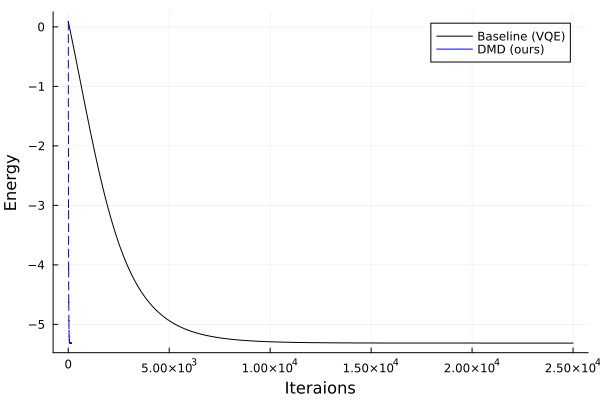

Demonstrate the prediction accuracy (with DMD prediction also included, which does not use as much per-step quantum resources as gradient-based calculation)


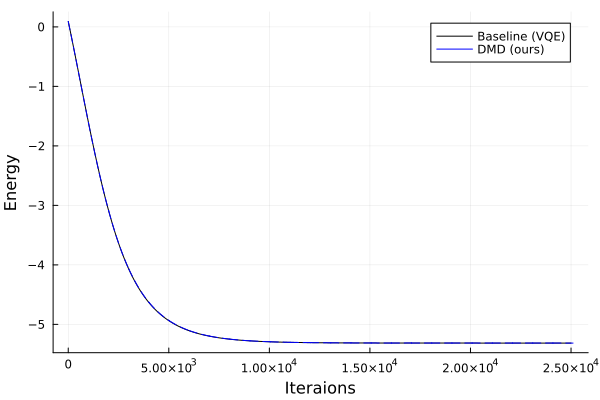

speedup ratio = 212.68666666666667


In [2]:
n_qubits = 5
ansatz_type = "HEA"
depth = 250
optimizer_type = "gd"
n_tot = 5000 * n_qubits
n_sim = 4
n_dmd = 1000
window_size = 1
n_pieces = 5 * n_qubits
lr = 5e-6
seed = 0
method_label="DMD"

quack_ising(
    n_qubits=n_qubits,
    t_field=0.5,
    pbc=1,
    n_tot=n_tot,
    n_sim=n_sim, n_dmd=n_dmd, window_size=window_size,
    n_pieces=n_pieces,
    ansatz_type="RealAmplitudes",
    depth=depth,
    optimizer_type=optimizer_type,
    lr=lr,
    print_every=100,
    plot_prediction=1,
    seed=seed,
    rng_type="Julia",
    save_params=false,
    use_early_termination=false,
    method_label=method_label,
)

# Example in the Smooth Optimization Regime (~10x speedup)

gatecount(circuit) = Dict{Type{<:AbstractBlock}, Int64}(ControlBlock{XGate, 1, 1} => 12, RotationGate{2, Float64, YGate} => 24)
num_params = nparameters(circuit) = 24
Ground state energy: -12.762569151024039
ini_params = Random.rand(Float64, num_params) = [0.8769033678050224, 0.7178744090083773, 0.6771085419598428, 0.27276542327669173, 0.11712991170488385, 0.21370618093217242, 0.6648072000092226, 0.19038291782539452, 0.8637063092887891, 0.7207683362057402, 0.7734484507682771, 0.17047040998298213, 0.37435457447521725, 0.9384149209302287, 0.8411002735197021, 0.14761833814179626, 0.49104462898119494, 0.8663984818313842, 0.6972373769488175, 0.6175079588047381, 0.472231714345129, 0.7669332335469764, 0.5535793093178042, 0.40896682148715113]
Step 100, energy = -10.303915098225303
Step 200, energy = -11.8124263315373
Step 300, energy = -12.536269023134798
Step 400, energy = -12.711560327063175
Step 500, energy = -12.744520375648882
Step 600, energy = -12.750042498120534
Step 700, energy = -12.

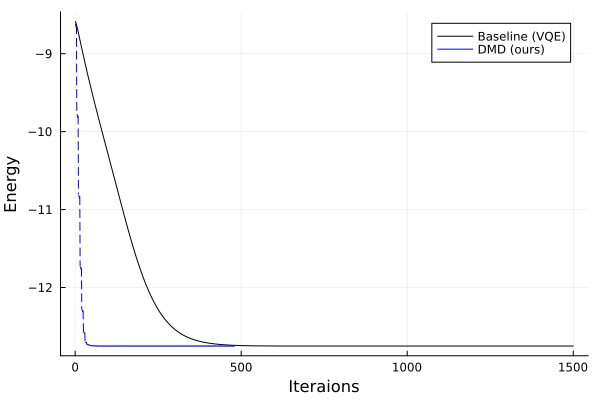

speedup ratio = 13.98490294751977


In [3]:
n_qubits = 12
ansatz_type = "RealAmplitudes"
depth = 2
optimizer_type = "adam"
n_tot = 1500
n_sim = 3
n_dmd = 60
window_size = 1
n_pieces = 96
lr = 2e-3
method_label="DMD"

quack_ising(
    n_qubits=n_qubits,
    t_field=0.5,
    pbc=1,
    n_tot=n_tot,
    n_sim=n_sim, n_dmd=n_dmd, window_size=window_size,
    n_pieces=n_pieces,
    ansatz_type="RealAmplitudes",
    depth=depth,
    optimizer_type=optimizer_type,
    lr=lr,
    print_every=100,
    plot_prediction=0,
    seed=10,
    rng_type="Julia",
    save_params=false,
    use_early_termination=false,
    method_label=method_label,
)